# Micronekton Lower-mesopelagic : LMTL vs SeapoPym (initial conditions)


In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from IPython.display import Markdown

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.configuration.no_transport.kernel_parameter import KernelParameter
from seapopym.logging.custom_logger import set_verbose
from seapopym.model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

set_verbose()

In [60]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({"figure.figsize": (10, 6), "axes.grid": True, "grid.alpha": 0.5, "grid.linestyle": "--"})


In [61]:
path_forcing = "/Users/adm-lehodey/Documents/Workspace/Data/phd/HOT/CMEMS/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1718149967802.nc"
path_bio = "/Users/adm-lehodey/Documents/Workspace/Data/phd/HOT/CMEMS/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1718150094521.nc"

forcing = xr.open_dataset(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
bio = xr.open_dataset(path_bio)

In [62]:
NB_YEARS = 4
bio = bio.isel(latitude=[0], longitude=[0], time=slice(0, 365 * NB_YEARS))
forcing = forcing.isel(latitude=[0], longitude=[0], time=slice(0, 365 * NB_YEARS))

In [63]:
display(Markdown("### Physics"))
display(forcing)
display(Markdown("### Biology"))
display(bio)

### Physics

<xarray.Dataset> Size: 82kB
Dimensions:              (time: 1460, depth: 3, latitude: 1, longitude: 1)
Coordinates:
  * depth                (depth) float32 12B 1.0 2.0 3.0
  * latitude             (latitude) float32 4B 22.08
  * longitude            (longitude) float32 4B -158.5
  * time                 (time) datetime64[ns] 12kB 1998-01-01 ... 2001-12-30
Data variables:
    T                    (time, depth, latitude, longitude) float32 18kB ...
    U                    (time, depth, latitude, longitude) float32 18kB ...
    V                    (time, depth, latitude, longitude) float32 18kB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float32 18kB ...
Attributes:
    Conventions:       CF-1.11
    title:             Physical forcings of global ocean low and mid trophic ...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_202211
    subset:date:       2024-06-11T23:52:47.809Z

### Biology

<xarray.Dataset> Size: 64kB
Dimensions:       (latitude: 1, longitude: 1, time: 1460)
Coordinates:
  * latitude      (latitude) float32 4B 22.08
  * longitude     (longitude) float32 4B -158.5
  * time          (time) datetime64[ns] 12kB 1998-01-01 ... 2001-12-30
Data variables:
    mnkc_epi      (time, latitude, longitude) float32 6kB ...
    mnkc_hmlmeso  (time, latitude, longitude) float32 6kB ...
    mnkc_lmeso    (time, latitude, longitude) float32 6kB ...
    mnkc_mlmeso   (time, latitude, longitude) float32 6kB ...
    mnkc_mumeso   (time, latitude, longitude) float32 6kB ...
    mnkc_umeso    (time, latitude, longitude) float32 6kB ...
    npp           (time, latitude, longitude) float32 6kB ...
    zeu           (time, latitude, longitude) float32 6kB ...
    zooc          (time, latitude, longitude) float32 6kB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-06-11T23:54:54.527Z

## Initialize the model


In [64]:
global_energy_coef = 0.0042
functional_type = FunctionalTypeParameter(
    lambda_temperature_0=(1 / 2109),
    gamma_lambda_temperature=0.125,
    tr_0=527,
    gamma_tr=-0.125,
)
lower_mesopelagic = FunctionalGroupUnit(
    name="lower_mesopelagic",
    migratory_type=MigratoryTypeParameter(day_layer=3, night_layer=3),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)

f_groups = FunctionalGroupParameter(functional_group=[lower_mesopelagic])
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]), primary_production=ForcingUnit(forcing=bio["npp"]), timestep="1D"
)
configuration = NoTransportConfiguration(
    forcing=p_param,
    functional_group=f_groups,
    kernel=KernelParameter(compute_initial_conditions=True),
)
micronekton_model = NoTransportModel.from_configuration(configuration=configuration)

2025-05-05 16:34:48,025 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-05-05 16:34:48,026 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Let's see how much memory is taking the model in the current state.


In [65]:
micronekton_model.expected_memory_usage

'The expected memory usage is 0.90 MB.'

In [66]:
micronekton_model.run()

In [67]:
biomass_results = micronekton_model.state.biomass.load()

In [68]:
micronekton_model.state


<xarray.Dataset> Size: 904kB
Dimensions:                       (time: 1460, latitude: 1, longitude: 1,
                                   functional_group: 1, cohort: 527, depth: 3)
Coordinates:
  * time                          (time) datetime64[ns] 12kB 1998-01-01 ... 2...
  * latitude                      (latitude) float32 4B 22.08
  * longitude                     (longitude) float32 4B -158.5
  * functional_group              (functional_group) int64 8B 0
  * cohort                        (cohort) int64 4kB 0 1 2 3 ... 523 524 525 526
  * depth                         (depth) float32 12B 1.0 2.0 3.0
Data variables: (12/29)
    biomass                       (functional_group, time, latitude, longitude) float64 12kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 12kB ...
    preproduction                 (functional_group, latitude, longitude, cohort) float64 4kB ...
    mortality_field               (functional_group, time, latitude, longitude) float64 12kB ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 769kB ...
    min_temperature               (functional_group, cohort) float64 4kB 50.1...
    ...                            ...
    max_timestep                  (functional_group, cohort) int64 4kB 1 ... 527
    mean_timestep                 (functional_group, cohort) float64 4kB 1.0 ...
    timestep                      int64 8B 1
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B True
    compute_preproduction         bool 1B False

In [69]:
# Prediction
biomass_results = biomass_results.pint.quantify().pint.to("g/m2").mean(["latitude", "longitude", "functional_group"])
# Seapodym LMTL
lmtl_mnk = bio[["mnkc_lmeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to("g/m2")
wet_to_carbon = 1 / 11.9
lmtl_mnk = lmtl_mnk * wet_to_carbon
lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))

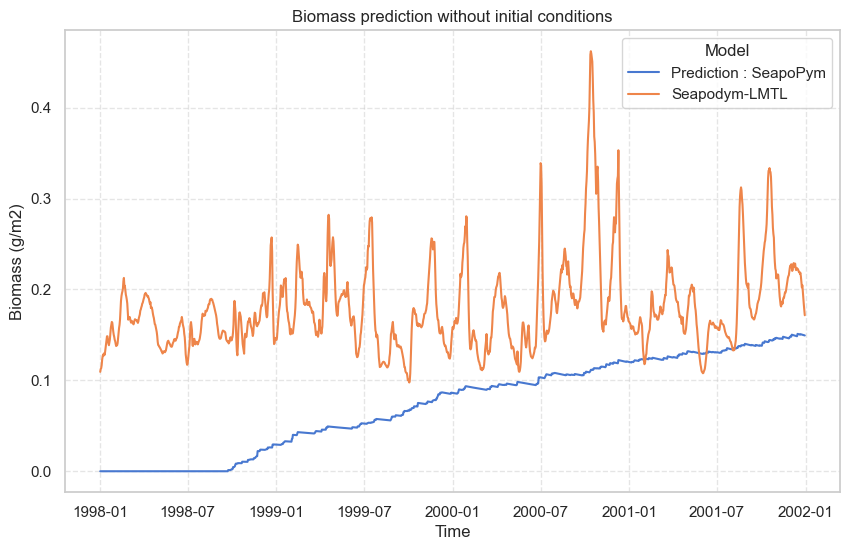

In [70]:
plot_without_init = pd.DataFrame(
    {
        "Prediction : SeapoPym": biomass_results.rename("Prediction : SeapoPym").pint.dequantify().to_series(),
        "Seapodym-LMTL": lmtl_mnk["mnkc_lmeso"].pint.dequantify().to_series(),
    }
)

plot_without_init = plot_without_init.reset_index().melt(id_vars="time", var_name="Model", value_name="Biomass (g/m2)")

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_without_init, x="time", y="Biomass (g/m2)", hue="Model")
plt.title("Biomass prediction without initial conditions")
plt.xlabel("Time")
plt.ylabel("Biomass (g/m2)")
plt.legend(title="Model")
plt.show()


---

## Let's try with initial conditions


In [71]:
initial_conditions = micronekton_model.export_initial_conditions().drop_vars("time")
initial_conditions

<xarray.Dataset> Size: 8kB
Dimensions:           (functional_group: 1, latitude: 1, longitude: 1,
                       cohort: 527)
Coordinates:
  * latitude          (latitude) float32 4B 22.08
  * longitude         (longitude) float32 4B -158.5
  * functional_group  (functional_group) int64 8B 0
  * cohort            (cohort) int64 4kB 0 1 2 3 4 5 ... 521 522 523 524 525 526
Data variables:
    biomass           (functional_group, latitude, longitude) float64 8B 0.00...
    preproduction     (functional_group, latitude, longitude, cohort) float64 4kB ...

In [72]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]),
    primary_production=ForcingUnit(forcing=bio["npp"]),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["biomass"]),
    initial_condition_production=ForcingUnit(forcing=initial_conditions["preproduction"]),
    timestep="1D",
)

configuration = NoTransportConfiguration(functional_group=f_groups, forcing=p_param)
micronekton_model_with_initial_conditions = NoTransportModel.from_configuration(configuration=configuration)

2025-05-05 16:34:51,465 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-05-05 16:34:51,466 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



In [73]:
micronekton_model_with_initial_conditions.run()

In [74]:
biomass_results = micronekton_model_with_initial_conditions.state.biomass.load()

In [75]:
# Prediction
biomass_results = biomass_results.pint.quantify().pint.to("g/m2").mean(["latitude", "longitude", "functional_group"])
# Seapodym LMTL
lmtl_mnk = bio[["mnkc_lmeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to("g/m2")
wet_to_carbon = 1 / 11.9
lmtl_mnk = lmtl_mnk * wet_to_carbon
lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))

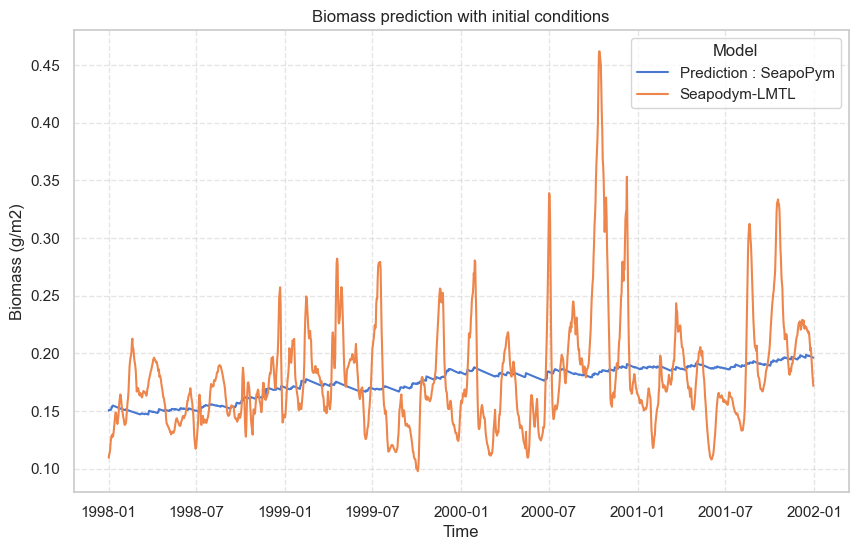

In [76]:
plot_with_init = pd.DataFrame(
    {
        "Prediction : SeapoPym": biomass_results.rename("Prediction : SeapoPym").pint.dequantify().to_series(),
        "Seapodym-LMTL": lmtl_mnk["mnkc_lmeso"].pint.dequantify().to_series(),
    }
)

plot_with_init = plot_with_init.reset_index().melt(id_vars="time", var_name="Model", value_name="Biomass (g/m2)")
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_with_init, x="time", y="Biomass (g/m2)", hue="Model")
plt.title("Biomass prediction with initial conditions")
plt.xlabel("Time")
plt.ylabel("Biomass (g/m2)")
plt.legend(title="Model")
plt.show()
